In [1]:
import os
import glob
import numpy as np
import pandas as pd
import scipy as sp
import scipy.optimize
import scipy.stats
import scipy.ndimage
import matplotlib.pyplot as plt
from astropy.cosmology import Planck13
from mpl_toolkits.axes_grid1 import make_axes_locatable
cosmo = Planck13

In [2]:
os.chdir("/home/mitchell/Documents/masters/masters/data/server/run_43/outputs")
os.getcwd()
output = np.loadtxt('output_342000_pairs.txt',delimiter=',')

In [3]:
def radMask(index,radius,array):
  a,b = index
  nx,ny = array.shape
  y,x = np.ogrid[-a:nx-a,-b:ny-b]
  mask = x*x + y*y <= radius*radius
  return mask

cen = (169/2+1,169/2+1)
out_mask = radMask(cen,80,output).astype(int)
in_mask = radMask(cen,60,output).astype(int)
annul_mask = np.subtract(out_mask,in_mask).astype(bool)
annular_mean = sp.ndimage.mean(output,labels = annul_mask)
output_less_mean = output-annular_mean
# print(annular_mean)
# print(output_less_mean)
lft_halo = output[:,44]
centre = int(len(output)/2)+1



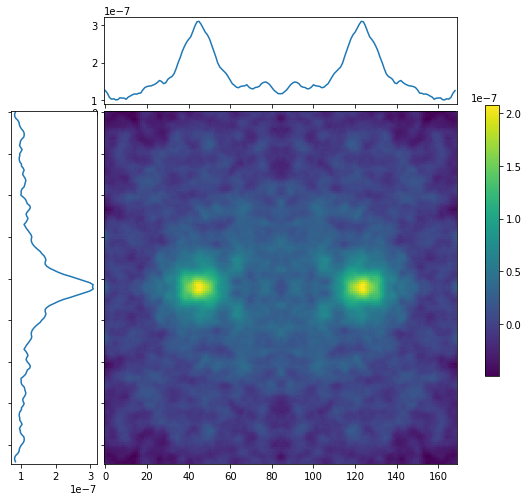

In [4]:
fig, axImage = plt.subplots(figsize=(10, 10))

axImage.imshow(output_less_mean)
divider = make_axes_locatable(axImage)
axSliceX = divider.append_axes("top", 1.2, pad=0.1, sharex=axImage)
axSliceY = divider.append_axes("left", 1.2, pad=0.1, sharey=axImage)

axSliceX.xaxis.set_tick_params(labelbottom=False)
axSliceY.yaxis.set_tick_params(labelleft=False)

central_line_x = output[centre,:]
axSliceX.plot(central_line_x)

lft_halo = output[:,44]
axSliceY.plot(lft_halo,np.arange(len(lft_halo)))

im = axImage.pcolormesh(output_less_mean)
fig.colorbar(im,ax=axImage,shrink=0.5)
os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')
fig.savefig('Stack.png')
plt.show()
plt.close()

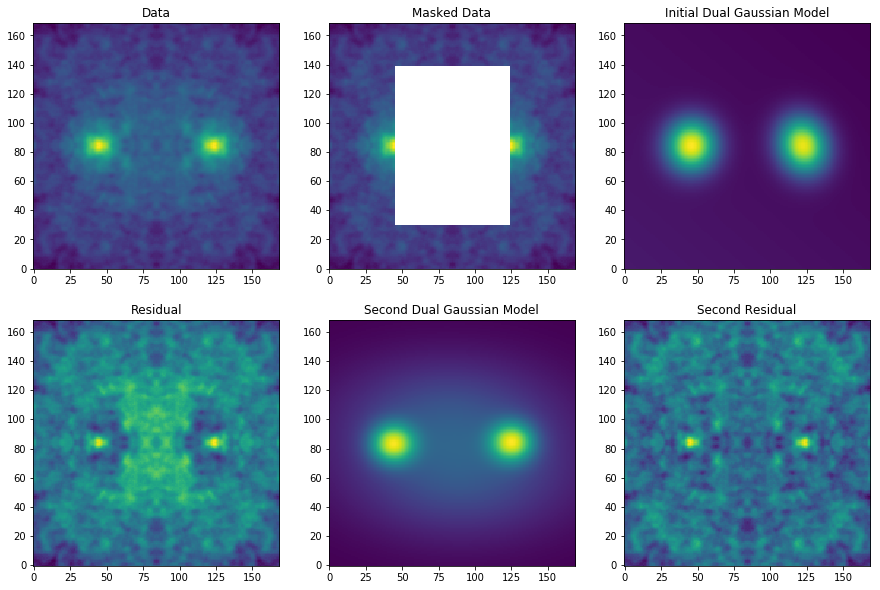

In [5]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

@custom_model
def sum_of_2Dgaussians(x, y, amplitude=1., mean_x1=0., mean_y1=0., mean_x2=0., mean_y2=0., sigma_x=1.,sigma_y=1.):
    return amplitude * np.exp(-( (x-mean_x1)**2/2./sigma_x**2 + (y-mean_y1)**2/2./sigma_y**2 ) ) \
        + amplitude * np.exp(-( (x-mean_x2)**2/2./sigma_x**2 + (y-mean_y2)**2/2./sigma_y**2 ) )

fit_data = np.ma.masked_array(output, mask=np.zeros_like(output))
fit_data .mask[30:169-30,45:169-45] = True 

# p_init = models.Polynomial2D(degree=4)
g1_init = models.Gaussian2D(amplitude=1e-7, x_mean=45, y_mean=85, x_stddev=20, y_stddev=20) \
    + models.Gaussian2D(amplitude=1e-7, x_mean=45, y_mean=85, x_stddev=20, y_stddev=20) \
    + models.Gaussian2D(amplitude=4e-7, x_mean=45, y_mean=85, x_stddev=5, y_stddev=5) \
    + models.Gaussian2D(amplitude=4e-7, x_mean=125, y_mean=85, x_stddev=5, y_stddev=5) \
    + models.Const2D(amplitude=1e-6) 
fit_g1 = fitting.LevMarLSQFitter()

g2_init = sum_of_2Dgaussians(amplitude=1e-7, mean_x1=45, mean_x2=125, mean_y1=85, mean_y2=85, sigma_x=12, sigma_y=12) \
    + sum_of_2Dgaussians(amplitude=4e-7, mean_x1=45, mean_x2=125, mean_y1=85, mean_y2=85, sigma_x=12, sigma_y=12) \
    + models.Const2D(amplitude=1e-7)
fit_g2 = fitting.LevMarLSQFitter()

y,x = np.mgrid[:len(output),:len(output)]

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    g1 = fit_g1(g1_init, x, y, fit_data)
    g2 = fit_g2(g2_init,x,y,fit_data)


    
plt.figure(figsize=(15,10))
plt.subplot(2, 3, 1)
plt.imshow(output_less_mean, origin='lower', interpolation='nearest')
plt.title("Data")

plt.subplot(2, 3, 2)
plt.imshow(fit_data, origin='lower', interpolation='nearest')
plt.title("Masked Data")

plt.subplot(2, 3, 3)
plt.imshow(g1(x, y), origin='lower', interpolation='nearest')
plt.title("Initial Dual Gaussian Model")

plt.subplot(2, 3, 4)
plt.imshow(output_less_mean - g1(x, y), origin='lower', interpolation='nearest')
plt.title("Residual")

plt.subplot(2,3,5)
plt.imshow(g2(x,y),origin='lower',interpolation='nearest')
plt.title("Second Dual Gaussian Model")

plt.subplot(2,3,6)
plt.imshow(output_less_mean-g2(x,y),origin='lower',interpolation='nearest')
plt.title("Second Residual")

plt.savefig("data_fitting.png")

In [6]:
print(g1)
print(g2)

Model: CompoundModel3
Inputs: (u'x', u'y')
Outputs: (u'z',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian2D(amplitude=0.0000001, x_mean=45., y_mean=85., x_stddev=20., y_stddev=20., theta=0.)>

    [1]: <Gaussian2D(amplitude=0.0000001, x_mean=45., y_mean=85., x_stddev=20., y_stddev=20., theta=0.)>

    [2]: <Gaussian2D(amplitude=0.0000004, x_mean=45., y_mean=85., x_stddev=5., y_stddev=5., theta=0.)>

    [3]: <Gaussian2D(amplitude=0.0000004, x_mean=125., y_mean=85., x_stddev=5., y_stddev=5., theta=0.)>

    [4]: <Const2D(amplitude=0.000001)>
Parameters:
         amplitude_0           x_mean_0      ...      amplitude_4      
    --------------------- ------------------ ... ----------------------
    1.577399065799525e-05 -3802.724125260685 ... 1.0021865453547878e-07
Model: CompoundModel5
Inputs: ('x', 'y')
Outputs: ('x',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <sum_of_2Dgaussians(amplitude=0.0000001, mean_x1=45., me

In [7]:

# annular_mean = sp.ndimage.mean(output,labels = mask)
# print(annular_mean)

In [8]:
# plt.imshow(output[:,:]-annular_mean)
# plt.colorbar()
def radial_dist(loc,array):
    x,y = np.meshgrid(np.arange(array.shape[1]),np.arange(array.shape[0]))
    R = np.sqrt((x-loc[0])**2+(y-loc[1])**2).astype(int)
    return R

In [9]:
# qtr = output[:len(output)/2,:len(output)/2]
# # plt.imshow(qtr)
# # x,y = np.meshgrid(np.arange(qtr.shape[1]),np.arange(qtr.shape[0]))
# # R = np.sqrt((x-44)**2+(y-85)**2).astype(int)
# # print(R)
# # plt.imshow(R)
# radii = radial_dist((44,85),qtr)
# plt.imshow(radii)
# # print(radii)
# plt.close()

# r_lam = lambda r : qtr[(R >= r-.02) & (R < r+.02)].mean()
# ar = np.linspace(1,95,num=95)
# means = np.vectorize(r_lam)(ar)
# plt.plot(means)

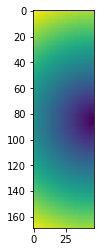

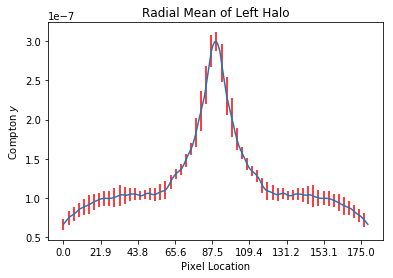

In [10]:
cut = output[:,:47]
radii = radial_dist((47,85),cut)
plt.imshow(radii)
plt.show()
plt.close()
r_lam = lambda r : cut[(radii >= r-1.5) & (radii < r+1.5)].mean()
r_std = lambda m : cut[(radii >= m-1.5) & (radii < m+1.5)].std()
ar = np.linspace(1,90,num=90)
means = np.vectorize(r_lam)(ar)
mean_ref = means[::-1]

std_devs = np.vectorize(r_std)(ar)
relect = std_devs[::-1]
halo_stdev = np.concatenate((relect,std_devs))

halo = np.concatenate((mean_ref,means))
# plt.plot(halo)
# plt.plot(halo_stdev)
plt.errorbar(np.arange(len(halo)),halo,halo_stdev,ecolor='r',errorevery=3)
plt.title("Radial Mean of Left Halo")
plt.xlabel("Pixel Location")
plt.xticks(np.linspace(0,175,num=9),label=np.linspace(-85,85,num=9))
plt.ylabel(r"Compton $y$")
os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')
plt.savefig("halo_shape.png")

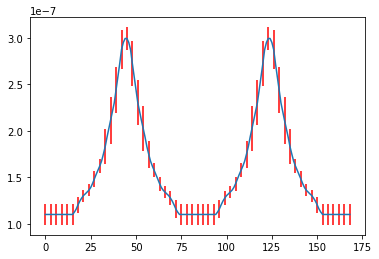

In [11]:
peak = halo[60:len(halo)-60]
height = peak[0]
two_halos = np.full_like(output[44],fill_value=height)
two_halos[15:75] = peak
two_halos[-75:-15] = peak

peak_err = halo_stdev[60:len(halo)-60]
err_height = peak_err[0]
two_halo_err = np.full_like(output[44],fill_value=err_height)
two_halo_err[15:75] = peak_err
two_halo_err[-75:-15] = peak_err

plt.errorbar(np.arange(len(two_halos)),two_halos,two_halo_err,ecolor='r',errorevery=3)
os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')
plt.savefig("halo_model_basic.png")

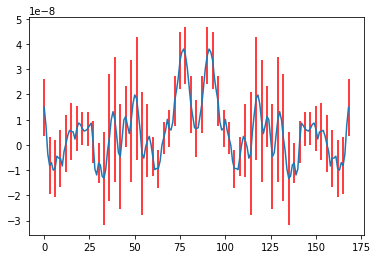

In [12]:
plt.errorbar(np.arange(len(central_line_x)),central_line_x-two_halos,two_halo_err,ecolor='r',errorevery=3)
os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')
plt.savefig("filament_basic.png")

In [13]:
# def rad_mean(array,angle,direction,centre):
    

# out_mask = radMask((len(qtr),44),91,qtr).astype(int)
# in_mask = radMask((len(qtr),44),90,qtr).astype(int)
# annul_mask = np.subtract(out_mask,in_mask).astype(bool)
# plt.imshow(annul_mask)

In [14]:
centre = int(len(output)/2)+1
print(centre)
central_line_x = output[centre,:]
# central_line_x_1 = output[centre,30:60]
# central_line_x_2 = output[centre,110:140]
central_line_y = output[:,centre]

85


In [15]:
# def _1gaussian(x, amp1,cen1,sigma1):
#     return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cen1)**2)/((2*sigma1)**2)))

# def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
#     return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cen1)**2)/((2*sigma1)**2))) +\
#            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp(-((x-cen2)**2)/((2*sigma2)**2)))

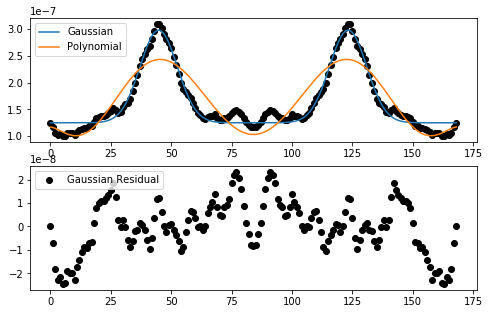

In [16]:
y_array_gauss = central_line_x
x_array = np.arange(len(central_line_x))

p_init = models.Polynomial1D(degree=8) + models.Const1D(amplitude = 1e-7)
p_fit = fitting.LevMarLSQFitter()

p = p_fit(p_init,x_array,y_array_gauss)

g_init = models.Gaussian1D(amplitude=4e-7, mean=45, stddev=2.)\
    + models.Gaussian1D(amplitude=4e-7, mean=125, stddev=2.)\
    + models.Const1D(amplitude=1e-7)

#  models.Gaussian1D(amplitude=1e-7, mean=45, stddev=10.)
#  + models.Gaussian1D(amplitude=1e-7, mean=125, stddev=10.) \

fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x_array, y_array_gauss)
    
plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.plot(x_array, y_array_gauss, 'ko')
plt.plot(x_array, g(x_array), label='Gaussian')
plt.plot(x_array,p(x_array),label='Polynomial')
plt.legend(loc=2)

plt.subplot(2,1,2)
plt.plot(y_array_gauss-g(x_array),'ko',label='Gaussian Residual')
# plt.plot(y_array_gauss-p(x_array),'ro',label='Polynomial')
plt.legend(loc=2)

In [17]:
# amp1 = 3e-7
# cen1 = 48.0
# sigma1 = 5
# amp2 = 3e-7
# cen2 = 125
# sigma2 = 5

In [18]:
# popt_gauss, pcov_gauss = scipy.optimize.curve_fit(_1gaussian, x_array, y_array_gauss, p0=[amp1, cen1, sigma1])
# perr_gauss = np.sqrt(np.diag(pcov_gauss))

In [19]:
# popt_2gauss, pcov_2gauss = sp.optimize.curve_fit(_2gaussian, x_array, y_array_2gauss, p0=[amp1, cen1, sigma1, amp2, cen2, sigma2])
# perr_2gauss = np.sqrt(np.diag(pcov_2gauss))
# pars_1 = popt_2gauss[0:3]
# pars_2 = popt_2gauss[3:6]
# gauss_peak_1 = _1gaussian(x_array, *pars_1)
# gauss_peak_2 = _1gaussian(x_array, *pars_2)

NameError: name 'gauss_peak_1' is not defined

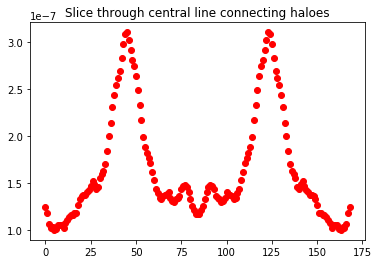

In [20]:
plt.plot(central_line_x,'ro')
plt.title("Slice through central line connecting haloes")
# plt.savefig("Central_Slice")
plt.plot(x_array, gauss_peak_1, "g")
plt.fill_between(x_array, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)
plt.plot(x_array, gauss_peak_2, "y")
plt.fill_between(x_array, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5) 

In [ ]:
pars_1

In [ ]:
pars_2

In [22]:
os.chdir('/home/mitchell/Documents/masters/masters/data/')
glob.glob('*')

['spt_sz_DES_catalogue.pkl',
 'galaxy_pairs.pkl',
 'cut_catalogue.pkl',
 'ra0hdec-57.5_ra0hdec-57p5_20140706_073929_090ghz.h5',
 'source_J2341_5119_90ghz.png',
 'unphysical_cat_2.pkl',
 'pairs.csv',
 'unphysical_cat_4.pkl',
 'DES_REDMAGIC_Manipulated.csv',
 'y_map.npy',
 'ra0dec-57p5_sum1000_090ghz.h5',
 'ra0dec-57p5_sum5000_150ghz.h5',
 'compton_y_map.png',
 'source_J2341_5119_150ghz.png',
 'high_res_map.png',
 'unphysical_pairs_4.pkl',
 'y_map.h5',
 'high_res.h5',
 'unphysical_cat_3.pkl',
 'ra0hdec-57.5_ra0hdec-57p5_20140706_073929_150ghz.h5',
 'unphysical_pairs_3.pkl',
 'Redshift_Distribution.png',
 'ra0dec-57p5_sum100Weighted_150ghz.h5',
 'LOS_Separation.png',
 'cutouts.pkl.gz',
 'cr_coadds',
 'redmagic_sva1_public_v6.3_faint.fits',
 'sri_J2337_5942_diff.png',
 'ra0dec-57p5_sum1000_150ghz.h5',
 'source_2337_5942_90ghz.png',
 'scratch',
 'ra0dec-57p5_sum_150ghz.h5',
 'Run_1',
 'planck2015',
 'ra0dec-57p5_sum100Weighted_090ghz.h5',
 'sri_J2337_5942_150ghz.png',
 'first_coadd_test_fbc

In [23]:
pairs = pd.read_pickle('spt_pol_galaxy_pairs.pkl')

In [24]:
cat = pd.read_pickle('spt_pol_DES_catalogue.pkl')

In [25]:
os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')

DescribeResult(nobs=342014, minmax=(0.15010099112987518, 0.8997664749622345), mean=0.46894798573542806, variance=0.01736099065107964, skewness=-0.15925775471498915, kurtosis=-0.10621488515786215)

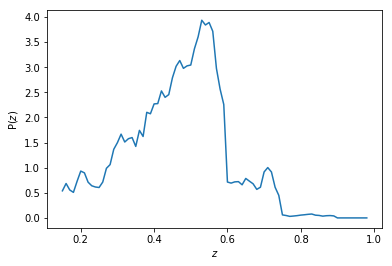

In [26]:
mean_redshift = np.mean([pairs.Z1,pairs.Z2],axis=0)
redshift_pdf = plt.hist(mean_redshift, density=True,stacked=True ,cumulative=False,label='Redshift PDF', histtype = 'step'
                        , alpha = 0.8,color = 'k',bins=np.arange(0.15,1.0,0.01))
plt.close()
plt.plot(redshift_pdf[1][:len(redshift_pdf[0])],redshift_pdf[0])
plt.xlabel('$z$')
plt.ylabel('P($z$)')
plt.savefig('Redshift_Distribution.png',dpi=500)
sp.stats.describe(mean_redshift)

/home/mitchell/Software/anaconda3/envs/cloud_2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


AttributeError: Unknown property dpi

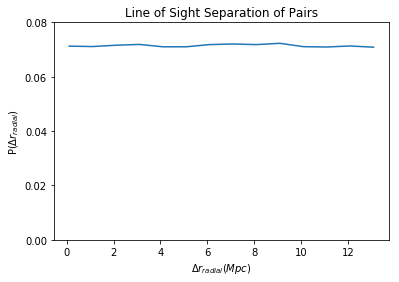

In [27]:
sep_los_pdf = plt.hist(pairs.SEP_LOS, normed=True, cumulative=False, label='PDF',
         histtype='step', alpha=0.8, color='k',bins=np.arange(0.1,14.5,1))
plt.close()
plt.plot(sep_los_pdf[1][:len(sep_los_pdf[0])],sep_los_pdf[0])
plt.xlabel('$\Delta r_{radial} (Mpc)$')
plt.ylabel('P($\Delta r_{radial}$)')
plt.ylim([0.0,0.08])
plt.yticks([0.0,0.02,0.04,0.06,0.08])
plt.title('Line of Sight Separation of Pairs',dpi=500)
plt.savefig('LOS_Separation.png')

In [ ]:
sep_trv_pdf = plt.hist(pairs.SEP_TRV, normed=True, cumulative=False, label='PDF',
         histtype='step', alpha=0.8, color='k',bins=np.arange(8.1,14.1,0.5))
plt.close()
plt.plot((sep_trv_pdf[1][:len(sep_trv_pdf[0])]),sep_trv_pdf[0])
plt.xlabel('$\Delta r_{tangential} (Mpc)$')
plt.ylabel('P($\Delta r_{tangential}$)')
# plt.ylim([0.0,0.08])
# plt.yticks([0.0,0.02,0.04,0.06,0.08])
plt.title('Transverse Separation of Pairs',dpi=500)
plt.savefig('TRV_Separation.png')

In [ ]:
cat.ZREDMAGIC.describe()

In [ ]:
sp.stats.describe(np.rad2deg(pairs.DEL_THETA)*60)

In [ ]:
sp.stats.describe(pairs.Sep*cosmo.h)

In [ ]:
os.chdir("/home/mitchell/Documents/masters/masters/scripts")
from cmb_footprint import footprint
fp = footprint.SurveyStack('PLANCK-DUSTPOL', projection='mollweide', coord_plot='C', rot=[0,0],
                           config='/home/mitchell/Documents/masters/masters/scripts/cmb_footprint/footprint.cfg') 

fp.superimpose_survey_outline('DES-polygon', color='black', label='DES')
fp.superimpose_survey_outline('SPT-SZ-tot', color='blue',label='SPT SZ')
fp.superimpose_survey_outline('SPTpol', color='yellow')#,label='SPTpol')
os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')
plt.savefig("Survey_Outlines.png",dpi=500)

In [ ]:
os.chdir('/home/mitchell/Documents/masters/masters/data/server/run_42/steps/')
firstcut = np.loadtxt('1_firstcut.txt',delimiter = ',')
rotated = np.loadtxt('1_rotated.txt',delimiter = ',')
rescaled = np.loadtxt('1_rescaled.txt',delimiter = ',')
second_cut = np.loadtxt('1_secondcut.txt',delimiter = ',')

In [ ]:
plt.imshow(firstcut)
plt.colorbar()
mask = np.zeros_like(firstcut)
plt.imshow(mask,alpha=0.2)